In [346]:
!pwd

/home/m.shah/projects/projects/notebooks


In [347]:
with open("../h_L8-W6404>>1.pickle", 'rb') as history22:
    history22 = pickle.load(history22)

In [255]:
import numpy as np
import pandas as pd
import pickle
import os, glob
import logging
import seaborn as sns

In [256]:
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras.callbacks import CSVLogger

In [258]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tabulate

In [3]:
path = os.getcwd()
path

'/home/m.shah/projects/projects/notebooks'

* <a href = "https://stackoverflow.com/questions/9321741/printing-to-screen-and-writing-to-a-file-at-the-same-time"> Tutorial for Logging in python, I used here: </a>

In [9]:
logfile = "/home/m.shah/projects/models/kaggle-models/LSTM/logs.log"
logging.basicConfig(filename = logfile, filemode='a', format='%(name)s - %(levelname)s - %(message)s', level = logging.DEBUG)
logging.getLogger().setLevel(0)

In [14]:
# ------ Console Logger ------
c_handler = logging.StreamHandler()
c_handler.setLevel(20)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
c_handler.setFormatter(formatter)
console = logging.getLogger('c-logger')
# ----- file Logger ------
f_handler = logging.FileHandler(logfile)
f_handler.setLevel(logging.DEBUG)
f_handler.setFormatter(formatter)
file = logging.getLogger('f-logger')

if (console.hasHandlers()):
    console.handlers.clear()
if (file.hasHandlers()):
    file.handlers.clear()
    
console.addHandler(c_handler)
file.addHandler(f_handler)

In [11]:
file.debug('df')
file.info('if')
file.warning('fw')
file.error('fe')

In [15]:
console.debug('test')
console.info('How quickly daft jumping zebras vex.')
console.warning( 'Jail zesty vixen who grabbed pay from quack.')
console.error('TEST')

c-logger    : INFO     How quickly daft jumping zebras vex.
c-logger    : WARNING  Jail zesty vixen who grabbed pay from quack.
c-logger    : ERROR    TEST


## Loading Data

In [260]:
dfs = []

for filename in glob.glob(os.path.join(path, "../data/simulated-data-raw/", "*.pkl")):
    with open(filename, 'rb') as f:
        temp = pd.read_pickle(f)
        dfs.append(temp)
df = pd.DataFrame()
df = df.append(dfs)

In [261]:
df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 7]]

In [271]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO,TX_FRAUD
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [21]:
df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD_SCENARIO',
       'TX_FRAUD'],
      dtype='object')

In [214]:
!pwd

/home/m.shah/projects/projects/notebooks


In [281]:
with open("../dg_x.pickle", "rb") as f:
    dg_x = pickle.load(f)

In [301]:
c = [column for column in dg_x.columns if not column.startswith(('CU','TERMINAL_ID'))]
c.append([column for column in dg_x.columns if not column.startswith(('CU','TERMINAL_ID'))])

In [302]:
c

['TX_AMOUNT',
 'TX_TIME_SECONDS',
 'TX_TIME_DAYS',
 'WEEK_DAY_0',
 'WEEK_DAY_6',
 'TX_FRAUD_SCENARIO_0',
 'TX_FRAUD_SCENARIO_1',
 'TX_FRAUD_SCENARIO_3',
 ['TX_AMOUNT',
  'TX_TIME_SECONDS',
  'TX_TIME_DAYS',
  'WEEK_DAY_0',
  'WEEK_DAY_6',
  'TX_FRAUD_SCENARIO_0',
  'TX_FRAUD_SCENARIO_1',
  'TX_FRAUD_SCENARIO_3']]

In [283]:
for c in dg_x.columns:
    if c.startswith(('CU','TERMINAL_ID')):
        continue
    else:
        print(c)

TX_AMOUNT
TX_TIME_SECONDS
TX_TIME_DAYS
WEEK_DAY_0
WEEK_DAY_6
TX_FRAUD_SCENARIO_0
TX_FRAUD_SCENARIO_1
TX_FRAUD_SCENARIO_3


In [276]:
dg_x[48:60]

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_0,TERMINAL_ID_1,TERMINAL_ID_2,TERMINAL_ID_4,TERMINAL_ID_6,TERMINAL_ID_7,...,TERMINAL_ID_9991,TERMINAL_ID_9992,TERMINAL_ID_9993,TERMINAL_ID_9995,TERMINAL_ID_9999,WEEK_DAY_0,WEEK_DAY_6,TX_FRAUD_SCENARIO_0,TX_FRAUD_SCENARIO_1,TX_FRAUD_SCENARIO_3
2630,27,0.103549,31977,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2681,27,0.257392,32282,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3647,27,0.178680,37690,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3809,27,0.155699,38452,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
6806,27,0.248774,54388,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7622,27,0.336943,59621,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
8568,27,0.153578,67723,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9964,27,0.216997,99146,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
9980,27,0.394087,99418,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
696,28,0.371680,16260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [277]:
dg_x[295:306]

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_0,TERMINAL_ID_1,TERMINAL_ID_2,TERMINAL_ID_4,TERMINAL_ID_6,TERMINAL_ID_7,...,TERMINAL_ID_9991,TERMINAL_ID_9992,TERMINAL_ID_9993,TERMINAL_ID_9995,TERMINAL_ID_9999,WEEK_DAY_0,WEEK_DAY_6,TX_FRAUD_SCENARIO_0,TX_FRAUD_SCENARIO_1,TX_FRAUD_SCENARIO_3
10082,148,0.201573,100946,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1391,149,0.280108,23433,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2298,149,0.104521,29910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2930,149,0.141159,33789,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
5277,149,0.104344,45896,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
5307,149,0.206479,46043,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
6354,149,0.205993,51799,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7752,149,0.164317,60636,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
8279,149,0.201618,64829,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9192,149,0.321342,76741,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [252]:
np.where(dg_x['CUSTOMER_ID']==149)

(array([296, 297, 298, 299, 300, 301, 302, 303, 304]),)

In [247]:
dg_x['CUSTOMER_ID'].iloc[48:56].eq()

2630    27
2681    27
3647    27
3809    27
6806    27
7622    27
8568    27
9964    27
Name: CUSTOMER_ID, dtype: object

In [154]:
dj = df.iloc[:int(0.006*df.shape[0])]

In [156]:
df.shape

(1754155, 9)

In [303]:
str((np.array(self.data[self.roll_base[0]].value_counts().values()) > window_size).sum())

NameError: name 'self' is not defined

In [305]:
a = [2]
a.append(3)

In [304]:
c_ids = np.array(list(dg_x.sort_values(by = 'CUSTOMER_ID')['CUSTOMER_ID'].value_counts().to_dict().keys()))
c_vals = np.array(list(dg_x.sort_values(by = 'CUSTOMER_ID')['CUSTOMER_ID'].value_counts().to_dict().values()))

In [250]:
c_vals[:26]

array([12, 11, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9])

In [251]:
sorted(c_ids[:26])

[27,
 149,
 154,
 454,
 597,
 818,
 841,
 918,
 939,
 987,
 1016,
 1470,
 1874,
 2850,
 2991,
 3158,
 3176,
 3230,
 3275,
 3511,
 3682,
 4036,
 4369,
 4374,
 4396,
 4429]

In [201]:
(c_vals >= 8).sum()

73

In [205]:
c_ids[:73]

array([ 818,  841,  939, 3176, 4396,  154, 2850, 1874,  454,  149, 3511,
       1016, 4369, 4036,  987,  918, 4374,  597, 2991,   27, 1470, 3230,
       4429, 3682, 3158, 3275, 1196, 1193, 4305, 2768, 4090,  314, 1235,
       2899, 4282, 3306, 1548, 3424,  186, 1109, 1047, 3404, 2404, 3342,
       4800, 1706, 1663,  960,  840, 2108, 2110, 1958,  354, 3940, 3765,
       4032, 4404, 4961, 4784,  220, 1839, 2217, 1254,  134, 4936, 4639,
       4781, 4928, 1246,  935,  832, 2355,  842])

In [208]:
dj = dj.sort_values(by = ['CUSTOMER_ID'])

In [209]:
np.where(dj['CUSTOMER_ID'] == 818)

(array([1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743,
        1744]),)

In [213]:
dj[1732:1750]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
3317,3317,2018-04-01 09:58:09,817,2615,13.95,35889,0,0,0
9662,9662,2018-04-02 01:46:11,818,3353,18.16,92771,1,0,0
639,639,2018-04-01 04:16:18,818,7481,95.04,15378,0,0,0
591,591,2018-04-01 04:04:29,818,6056,26.77,14669,0,0,0
9865,9865,2018-04-02 02:57:53,818,2319,108.51,97073,1,0,0
5558,5558,2018-04-01 13:11:20,818,4137,43.09,47480,0,0,0
6265,6265,2018-04-01 14:15:56,818,6916,64.08,51356,0,0,0
3696,3696,2018-04-01 10:31:09,818,6916,56.51,37869,0,0,0
3911,3911,2018-04-01 10:51:16,818,6916,22.73,39076,0,0,0
2931,2931,2018-04-01 09:23:13,818,1024,87.56,33793,0,0,0


## Preprocessing

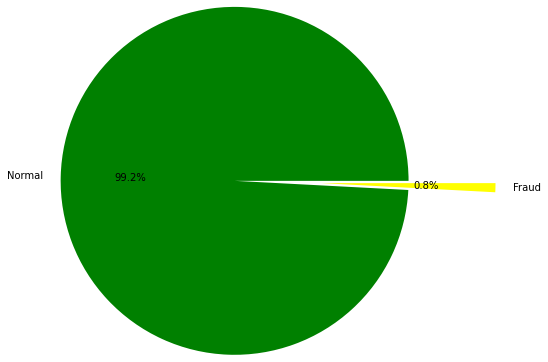

In [17]:
portions = df["TX_FRAUD"].value_counts().to_dict()
plt.pie(portions.values(), 
        portions.keys(),
        labels = ["Normal", "Fraud"], 
        radius = 2,
        autopct='%1.1f%%',
       colors = ["green", "yellow"])
plt.show()

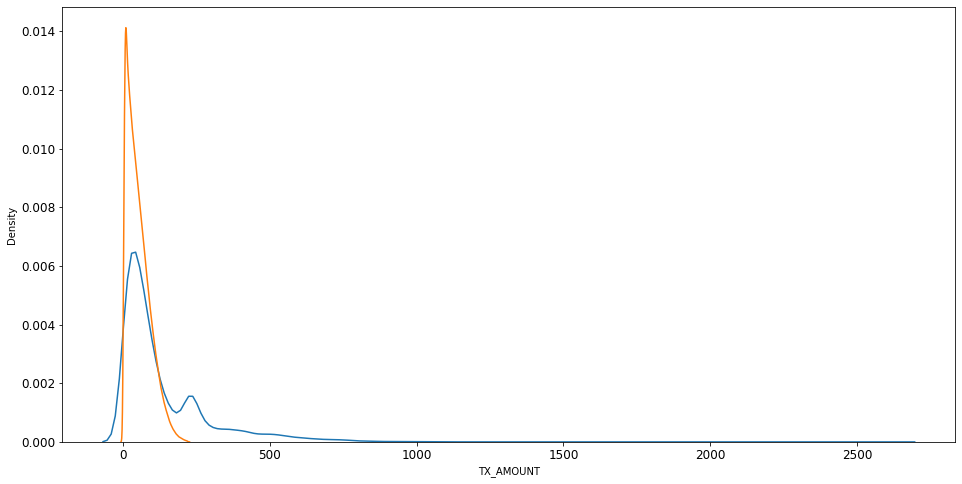

In [12]:
feature = 'TX_AMOUNT'
plt.figure(figsize = (16, 8))
sns.kdeplot(data = df.loc[df['TX_FRAUD'] == 1]['TX_AMOUNT'])
sns.kdeplot(data = df.loc[df['TX_FRAUD'] == 0]['TX_AMOUNT'])
plt.xlabel(feature, fontsize=10)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [106]:
customer_tx_count = dgg[:]["CUSTOMER_ID"].value_counts().to_dict()

In [107]:
customer_tx_count

{632: 5,
 1016: 4,
 515: 4,
 4736: 4,
 3784: 3,
 2917: 3,
 865: 3,
 67: 3,
 2275: 3,
 3445: 3,
 354: 3,
 356: 3,
 447: 3,
 3297: 3,
 2404: 3,
 3618: 3,
 1151: 3,
 1885: 3,
 204: 3,
 423: 3,
 1531: 3,
 1037: 3,
 3771: 3,
 1894: 3,
 3653: 3,
 1953: 3,
 1608: 3,
 183: 3,
 3258: 3,
 134: 3,
 3231: 3,
 139: 3,
 3744: 3,
 1410: 3,
 81: 3,
 2092: 3,
 2707: 3,
 1802: 3,
 4742: 3,
 4405: 3,
 1432: 3,
 3898: 3,
 1470: 3,
 1106: 3,
 4374: 3,
 2991: 3,
 4418: 3,
 1712: 2,
 4434: 2,
 841: 2,
 842: 2,
 4933: 2,
 4465: 2,
 1719: 2,
 4489: 2,
 2431: 2,
 4554: 2,
 1708: 2,
 98: 2,
 1705: 2,
 818: 2,
 4904: 2,
 4533: 2,
 4574: 2,
 3733: 2,
 1821: 2,
 1687: 2,
 4521: 2,
 833: 2,
 2337: 2,
 418: 2,
 724: 2,
 410: 2,
 1799: 2,
 2340: 2,
 2953: 2,
 4876: 2,
 1795: 2,
 3341: 2,
 776: 2,
 888: 2,
 4205: 2,
 349: 2,
 884: 2,
 3501: 2,
 3826: 2,
 4309: 2,
 2916: 2,
 2390: 2,
 3814: 2,
 4322: 2,
 340: 2,
 870: 2,
 3791: 2,
 318: 2,
 388: 2,
 893: 2,
 4967: 2,
 382: 2,
 2352: 2,
 2900: 2,
 4477: 2,
 2425: 2,
 376

<AxesSubplot:ylabel='Density'>

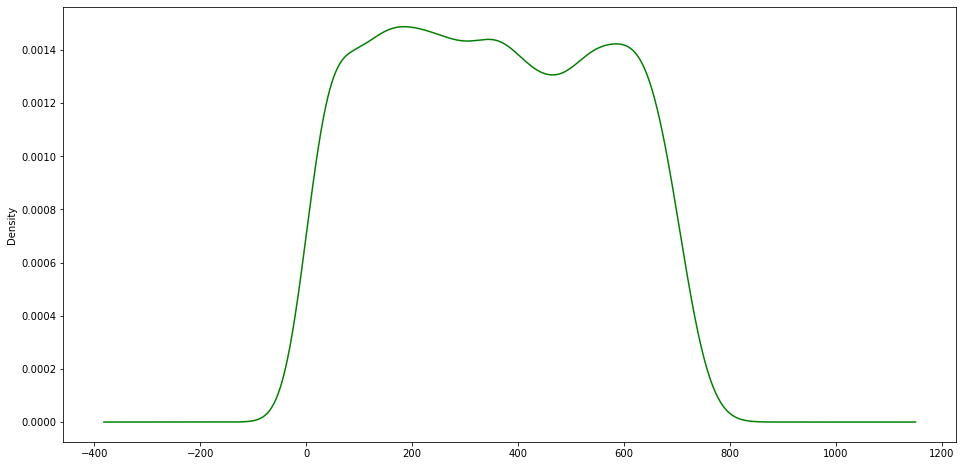

In [14]:
pd.Series(list(customer_tx_count.values())).plot(kind = 'density', figsize = (16,8), color = 'green')

In [333]:
a = [2, 2, 4]

In [345]:
class SIMPLE_LSTM:
    def __init__(self,
                 input_shape,
                 loss,
                 metrics,
                 drop_out = None,
                 lstm_layers = [50, 50, 50],
                 n_outputs = 1,
                 optimizer = 'adam'):

        # Model Layers
        self.model = Sequential()
        self.model.add(LSTM(lstm_layers[0], input_shape = input_shape, return_sequences = True))
        for i in range(1, len(lstm_layers)):
            self.mode.add(LSTM(lstm_layers[i], return_sequences = True))
            if drop_out is not None:
                self.model(Dropout(drop_out))
        
        self.model.compile(loss=loss, 
                           optimizer=optimizer, 
                           metrics=metrics) #optimizer='rmsprop'
        self.model.build()
        print("Model Summary: \n\n", self.model.summary())
        
        #model's name
        self.model_name = "L" + "".join(map(str,lstm_layers)) + "-"
        self.model_name += "W" + str(input_shape[1])
        self.model_name += ">>" + str(n_outputs)


In [344]:
input_shape = (8, 6100)
loss = 'mse'
drop_out = 0.2
metrics = 'mae'
n_outputs = 1
optimizer = 'adam'
model = SIMPLE_LSTM(input_shape,
            lstm_layers = [128],
            loss = loss, 
            drop_out=drop_out,
            metrics = metrics)


In [338]:
str(a)[3]

' '

In [328]:
c = [str(lstm) for lstm in a]
c

['2', '2', '4']

In [331]:
c + "+"

TypeError: can only concatenate list (not "str") to list

In [329]:
"L"+"".join(c)

'L224'

In [313]:
len(a)

1

In [309]:
for i in range(1, 2):
    print(",")

,


In [306]:
[4257, 4625, 4752, 4813, 4850, 4874, 4898, 4910, 4919, 4925, 4930, 4938, 4942, 4944, 4945, 4948, 4950, 4952, 4956, 4957, 4961, 4961, 4961, 4962, 4964, 4965, 4966, 4969, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4970, 4971, 4974, 4974, 4974, 4974, 4974, 4974, 4974, 4974, 4974, 4974, 4975, 4975, 4975, 4975, 4976, 4976, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4977, 4978, 4978, 4978, 4978, 4978, 4978, 4978, 4978, 4978, 4978, 4979, 4980, 4980, 4980, 4980, 4980, 4980, 4980, 4980, 4980, 4980, 4980, 4981, 4981, 4981, 4981, 4981]

[4257,
 4625,
 4752,
 4813,
 4850,
 4874,
 4898,
 4910,
 4919,
 4925,
 4930,
 4938,
 4942,
 4944,
 4945,
 4948,
 4950,
 4952,
 4956,
 4957,
 4961,
 4961,
 4961,
 4962,
 4964,
 4965,
 4966,
 4969,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4970,
 4971,
 4974,
 4974,
 4974,
 4974,
 4974,
 4974,
 4974,
 4974,
 4974,
 4974,
 4975,
 4975,
 4975,
 4975,
 4976,
 4976,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4977,
 4978,
 4978,
 4978,
 4978,
 4978,
 4978,
 4978,
 4978,
 4978,
 4978,
 4979,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4980,
 4981,
 4981,
 4981,
 4981,
 4981]

In [149]:
customer = np.array([1, 2,2,2 , 4, 5, 6])
customer = np.array(set(customer))

In [140]:
#Feature Define
if "WEEK_DAY" not in df.columns:
    df.insert(7, "WEEK_DAY", df["TX_DATETIME"].apply(lambda x : x.weekday()))
file.info("'WEEK_DAY' added to featues.")
#Feature Selection
selected_features = ["CUSTOMER_ID",
                     "TERMINAL_ID",
                     'TX_AMOUNT', 
                     'TX_TIME_SECONDS', 
                     'TX_TIME_DAYS', 
                     "WEEK_DAY", 
                     "TX_FRAUD_SCENARIO"]
file.info('selected Features are:' + str(selected_features))

In [23]:
class Preprocessor:    
    def __init__(self, input_data, logger, global_path):
        self.logger = logger
        self.data = input_data
    def pre_process(self, 
                    feature_columns,
                    label_columns,
                    window_size = 128,
                    numericals = None,
                    categoricals = None,
                    test_train_split = 0.7,
                    roll_base = 'time',
                    drop_rollbase = True,
                    imbalanced = False):
        # ---------- 
        self.features = feature_columns
        self.labels = label_columns
        self.window_size = window_size
        self.drop_rollbase = drop_rollbase
        self.roll_base = roll_base
        self.customers = np.array([])
        self.test_train_split = test_train_split
        if 'TX_DATETIME' in feature_columns:
            self.data['TX_DATETIME'] = self.data['TX_DATETIME'].values.astype(float) 
        # ---------- Standardization ----------
        self.scaler(numericals)
        # ---------- Categorical features >> OneHotEncoding -------------
        if categoricals is not None:
            self.logger.info("Raw data shape:", str(self.data.shape))
            self.encode(categoricals)
            self.logger.info("Categorized data shape:", str(self.data.shape))
        # ---------- Rolling X and Y Tensors ---------
        self.x_tensor, self.y_tensor = self.roll(self.window_size)
        self.logger.info( "Input X by shape:", self.data.shape,"rolled to X Tensor by Shape:", self.x_tensor.shape)
        #---------- Test and Train split ------------
        self.train_idx = np.random.choice(self.x_tensor.shape[0], 
                                      int(self.x_tensor.shape[0]*self.test_train_split), replace=False)                      
        
        self.X_train = self.x_tensor[self.train_idx, :, :]
        self.X_test = np.delete(self.x_tensor, self.train_idx, axis=0)
        self.y_train = self.y_tensor[self.train_idx, ]
        self.y_test = np.delete(self.y_tensor, self.train_idx, axis=0)
        self.logger.info( "Preprocessing Done! \n")
        return self.X_train, self.X_test, self.y_train, self.y_test
                
    def encode(self, categoricals):
        if categoricals[0] is not None:
            self.data = pd.get_dummies(self.data, columns = categoricals[0])
        if categoricals[1] is not None:
            self.data = pd.get_dummies(self.data, columns = categoricals[1])
    
    def scaler(self, numericals):
        scaler = MinMaxScaler()
        self.data[numericals[0]] = scaler.fit_transform(self.data[numericals[0]])
        self.data[numericals[1]] = scaler.fit_transform(self.data[numericals[1]])
        file.info(str(numericals[0])+ " >> have been Normalized.")
        file.info(str(numericals[0])+ " >> have been Normalized.")

    def roll(self, window_size):
        x_filter = [col for col in self.data.columns if col.startswith(tuple(self.features))]
        y_filter = [col for col in self.data.columns if col.startswith(tuple(self.labels))]
        ix_tensor = np.zeros([(self.data.shape[0] - (window_size)) * window_size, len(x_filter)], dtype = 'float32')
        iy_tensor = np.zeros((0, len(y_filter)), dtype = 'float32')
        tensor_name = "W"+str(window_size)+"X"+str(self.data.shape[0])+"_"

        if self.roll_base == 'time':
            tensor_name = "T-" + tensor_name
            self.dg_x = self.data[x_filter]
            self.dg_y = self.data[y_filter]
            # - - - - - Check Drive files - - - - 
            if os.path.isfile(tensor_name +'ix_tensor.pickle'):
                console.info("- - - -  Tensors been founded on Local Drive - - - - ")
                with open(str(tensor_name + 'ix_tensor.pickle'), 'rb') as file:
                    ix_tensor = joblib.load(file)
                with open(str(tensor_name + 'iy_tensor.pickle'), 'rb') as file:
                    iy_tensor = joblib.load(file)
            else:
                # Rolling Loop for making ix_tensor
                for i in tqdm(range(self.dg_x.shape[0]-(window_size))):
                    s = np.array(self.dg_x[i:i+window_size], dtype='float32')
                    ix_tensor[(window_size*i):(window_size*(i+1)), :] = s
                    iy_tensor = np.vstack((iy_tensor, self.dg_y.iloc[i+window_size, ]))
                ix_tensor = ix_tensor.reshape(-1, window_size, np.shape(ix_tensor)[1])
                self.logger.info( "- - - - Writing X Tensor on Drive- - - -")
                with open(tensor_name + 'ix_tensor.pickle', 'wb') as file:
                    joblib.dump(ix_tensor, file)
                with open(tensor_name + 'iy_tensor.pickle', 'wb') as file:
                    joblib.dump(iy_tensor, file) 
        else:
            tensor_name = "R-"+tensor_name
            if os.path.isfile(tensor_name +'ix_tensor.pickle'):
                console.info("- - - -  Tensors been founded on Local Drive - - - - ")
                with open(str(tensor_name + 'ix_tensor.pickle'), 'rb') as file:
                    ix_tensor = joblib.load(file)
                with open(str(tensor_name + 'iy_tensor.pickle'), 'rb') as file:
                    iy_tensor = joblib.load(file)
            else:
                dg = self.data.sort_values(by = self.roll_base)
                self.dg_x = dg[x_filter]
                self.dg_y = dg[y_filter]
                print(self.dg_x.columns)
                del(dg)
                # ------- Rolling Looop -----
                i = 0
                j = 0
                while (i < self.dg_x.shape[0]-(window_size)):
                    if(self.dg_x[self.roll_base[0]].iloc[i + window_size] == self.dg_x[self.roll_base[0]].iloc[i + window_size - 1]):
                        s = np.array(self.dg_x[i:i + window_size], dtype='float32')
                        ix_tensor[(window_size*j):(window_size*(j+1)), :] = s
                        iy_tensor = np.vstack((iy_tensor, self.dg_y.iloc[i+window_size,:]))
                        self.customers = np.append(self.customers, self.dg_x[self.roll_base[0]][i + window_size])
                        j += 1
                        i += 1
                    else:
                        i += window_size
                        continue
                # -------- Drop RoleBase Column -----
                if self.drop_rollbase:
                    ix_tensor = np.delete(ix_tensor, self.dg_x.columns.get_loc(self.roll_base[0]), axis = 1)
                ix_tensor = ix_tensor[:len(iy_tensor)*window_size ,:].reshape(-1, window_size, ix_tensor.shape[1])
                iy_tensor = iy_tensor.reshape(-1, 1)
                # ------- Dump Tensors on Drive ------
                with open(tensor_name + 'ix_tensor.pickle', 'wb') as file:
                    joblib.dump(ix_tensor, file)
                with open(tensor_name + 'iy_tensor.pickle', 'wb') as file:
                    joblib.dump(iy_tensor, file) 
        return ix_tensor, iy_tensor

## Transaction Prediction

In [117]:
class LSTM_REGRESSION:
    def __init__(self,
                 input_shape,
                 lstm_units = 50,
                 lstm_layers = 3,
                 n_outputs = 1,
                 optimizer = 'adam',
                loss = 'mse',
                metrics = 'mae'):

        #Model Layers
        self.model = Sequential()
        self.model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences = True))#, return_sequences=True))            
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(lstm_units, return_sequences = True))            
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(lstm_units))            
        self.model.add(Dropout(0.2))
        self.model.add(Dense(n_outputs))
        
        self.model.compile(loss=loss, 
                           optimizer=optimizer, 
                           metrics=metrics) #optimizer='rmsprop'
        self.model.build()
        print("Model Summary: \n\n", self.model.summary())
        
        #model's name
        self.model_name = "L"+str(lstm_units)+"-"+ str(lstm_layers)
        self.model_name += "W" + str(input_shape[1])
        self.model_name += ">>" + str(n_outputs)
        self.model
        
    def train(self, train_x, train_y, batch_size = 100, epochs  =1):
        csv_logger = CSVLogger('/home/m.shah/projects/models/kaggle-models/training.log', append=True, separator=';')
        result = self.model.fit(train_x,
                                train_y, 
                                batch_size = batch_size,
                                validation_split = 0.2,
                                epochs = epochs,
                               callbacks=[csv_logger])
        return result
    def predict(self, test_x):
        return self.model.predict(test_x)
    def save(self, hitory):
        self.model.save(self.model_name)
        with open(str("h_"+self.model_name), 'wb') as file:
            joblib.dump(history.history, file)

In [128]:
with open("../te.pickle", "rb") as t:
    dgg = pickle.load(t)

In [134]:
dgg['CUSTOMER_ID'].iloc[:8].eq(dgg['CUSTOMER_ID'].iloc[16+8])

1126    False
2       False
1013    False
95      False
1464    False
845     False
1519    False
1583    False
Name: CUSTOMER_ID, dtype: bool

In [129]:
dgg.head(20)

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_2,TERMINAL_ID_7,TERMINAL_ID_8,TERMINAL_ID_9,TERMINAL_ID_22,TERMINAL_ID_24,...,TERMINAL_ID_9969,TERMINAL_ID_9975,TERMINAL_ID_9980,TERMINAL_ID_9982,TERMINAL_ID_9986,TERMINAL_ID_9988,TERMINAL_ID_9991,TERMINAL_ID_9995,WEEK_DAY_6,TX_FRAUD_SCENARIO_0
1126,1,0.038505,21081,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,0.722186,476,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1013,4,0.458447,20063,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
95,8,0.008970,4260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1464,20,0.094950,24191,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
845,22,0.097032,18303,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1519,23,0.101442,24650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1583,23,0.200605,25036,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
838,25,0.054760,18261,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
696,28,0.416076,16260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [118]:
dgg.sort_values(by = ["CUSTOMER_ID"])

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_2,TERMINAL_ID_7,TERMINAL_ID_8,TERMINAL_ID_9,TERMINAL_ID_22,TERMINAL_ID_24,...,TERMINAL_ID_9969,TERMINAL_ID_9975,TERMINAL_ID_9980,TERMINAL_ID_9982,TERMINAL_ID_9986,TERMINAL_ID_9988,TERMINAL_ID_9991,TERMINAL_ID_9995,WEEK_DAY_6,TX_FRAUD_SCENARIO_0
1126,1,0.038505,21081,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,0.722186,476,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1013,4,0.458447,20063,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
95,8,0.008970,4260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1464,20,0.094950,24191,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,4985,0.363051,25834,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
839,4988,0.569206,18263,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
633,4994,0.529858,15322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
202,4995,0.443084,7764,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [127]:
dgg.head(40)

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_2,TERMINAL_ID_7,TERMINAL_ID_8,TERMINAL_ID_9,TERMINAL_ID_22,TERMINAL_ID_24,...,TERMINAL_ID_9969,TERMINAL_ID_9975,TERMINAL_ID_9980,TERMINAL_ID_9982,TERMINAL_ID_9986,TERMINAL_ID_9988,TERMINAL_ID_9991,TERMINAL_ID_9995,WEEK_DAY_6,TX_FRAUD_SCENARIO_0
1126,1,0.038505,21081,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,0.722186,476,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1013,4,0.458447,20063,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
95,8,0.008970,4260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1464,20,0.094950,24191,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
845,22,0.097032,18303,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1519,23,0.101442,24650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1583,23,0.200605,25036,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
838,25,0.054760,18261,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
696,28,0.416076,16260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [123]:
dgg['CUSTOMER_ID'][:30]

1126     1
2        2
1013     4
95       8
1464    20
845     22
1519    23
1583    23
838     25
696     28
239     30
597     35
386     36
654     36
1557    37
1702    37
572     38
362     53
1623    53
177     55
1266    56
317     59
1033    64
495     67
782     67
1420    67
1482    68
726     69
401     77
1277    80
Name: CUSTOMER_ID, dtype: object

In [120]:
dgg[dgg['CUSTOMER_ID'] == 67]

,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TERMINAL_ID_2,TERMINAL_ID_7,TERMINAL_ID_8,TERMINAL_ID_9,TERMINAL_ID_22,TERMINAL_ID_24,...,TERMINAL_ID_9969,TERMINAL_ID_9975,TERMINAL_ID_9980,TERMINAL_ID_9982,TERMINAL_ID_9986,TERMINAL_ID_9988,TERMINAL_ID_9991,TERMINAL_ID_9995,WEEK_DAY_6,TX_FRAUD_SCENARIO_0
495,67,0.618118,13260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
782,67,0.359483,17366,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1420,67,0.343674,23711,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [122]:
pp = Preprocessor(df.iloc[:5000, :], logging.getLogger('pre-processor'))

In [123]:
train_x, test_x, train_y, test_y = pp.pre_process(selected_features, 
                               ['TX_AMOUNT'], 
                               numericals = [["TX_AMOUNT", "TX_TIME_SECONDS",'TX_TIME_DAYS'],["TX_AMOUNT"]],
                               categoricals = [["TERMINAL_ID", "WEEK_DAY", "TX_FRAUD_SCENARIO"],None], 
                               window_size = 8,
                               roll_base = ["CUSTOMER_ID", "TX_TIME_SECONDS"])

<ipython-input-121-fb6913b8ec43>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[numericals[0]] = scaler.fit_transform(self.data[numericals[0]])
/home/m.shah/.conda/envs/tensorflow/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-121-fb6913b8ec43>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

- - - -  X Tensor founded on Local Drive - - - - 
- - - -  Reading X TENSOR - - - - 


In [124]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((114, 128, 7147), (49, 128, 7147), (114, 1), (49, 1))

In [135]:
train_x[0, 0, :20]

array([0.1417091, 0.0434092, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ], dtype=float32)

In [118]:
model = LSTM_REGRESSION(train_x.shape[1:], n_outputs = train_y.shape[1], lstm_units = train_x.shape[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8, 8)              124384    
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 8)              544       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [119]:
model.model_name

'L8-3W3878>O1'

In [35]:
model

In [36]:
history = model.train(train_x, train_y, batch_size = 128, epochs = 2)

Epoch 1/2
2/2 [==============================] - 12s 3s/step - loss: 0.0905 - mae: 0.2426 - val_loss: 0.0764 - val_mae: 0.2138
Epoch 2/2
2/2 [==============================] - 0s 301ms/step - loss: 0.0737 - mae: 0.2114 - val_loss: 0.0690 - val_mae: 0.1962


In [39]:
model.save('model.h5', history)

In [48]:
del history2

In [93]:
with open("model_history.pickle", "rb") as file:
    history2 = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'model_history.pickle'

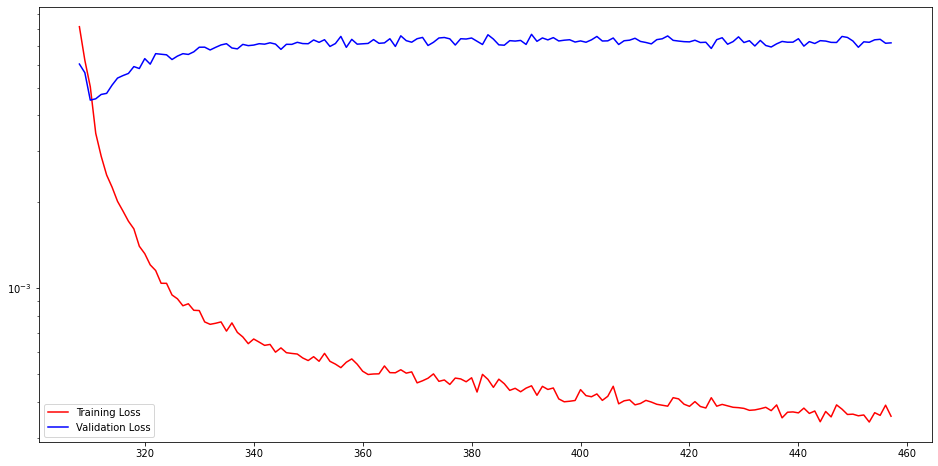

In [71]:
plt.figure(figsize = (16,8))
plt.plot(log.iloc[-150:,]['loss'], color = 'red', label= 'Training Loss')
plt.plot(log.iloc[-150:,]['val_loss'], color = 'blue', label = 'Validation Loss')
plt.legend()
plt.yscale("log")
plt.show()

In [130]:
with open("model_history22.pickle", "rb") as file:
    history22 = pickle.load(file)

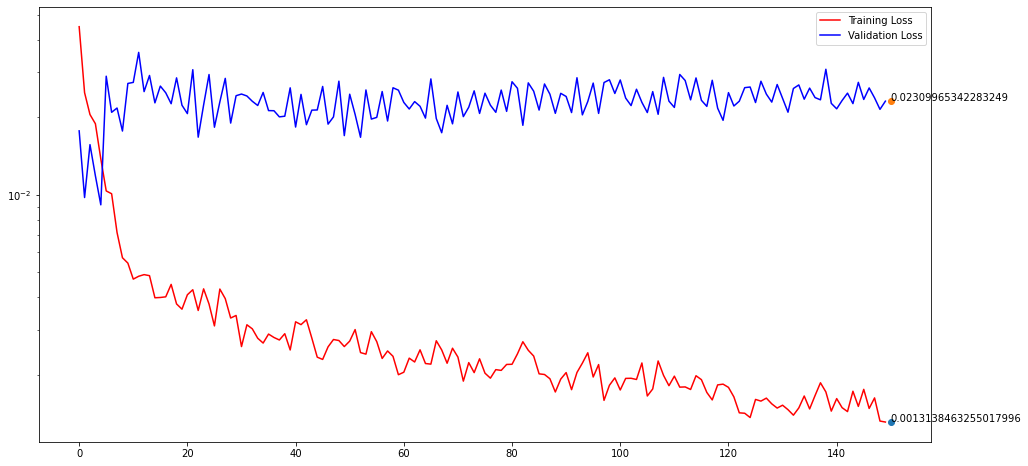

In [92]:
plt.figure(figsize = (16,8))
plt.plot(history22['loss'], color = 'red', label= 'Training Loss')
plt.plot(history22['val_loss'], color = 'blue', label = 'Validation Loss')
plt.scatter(150, history22['loss'][149])
plt.scatter(150, history22['val_loss'][149])
plt.annotate(history22['loss'][149], (150, history22['loss'][149]))
plt.annotate(history22['val_loss'][149], (150, history22['val_loss'][149]))

plt.legend()
plt.yscale("log")
plt.show()

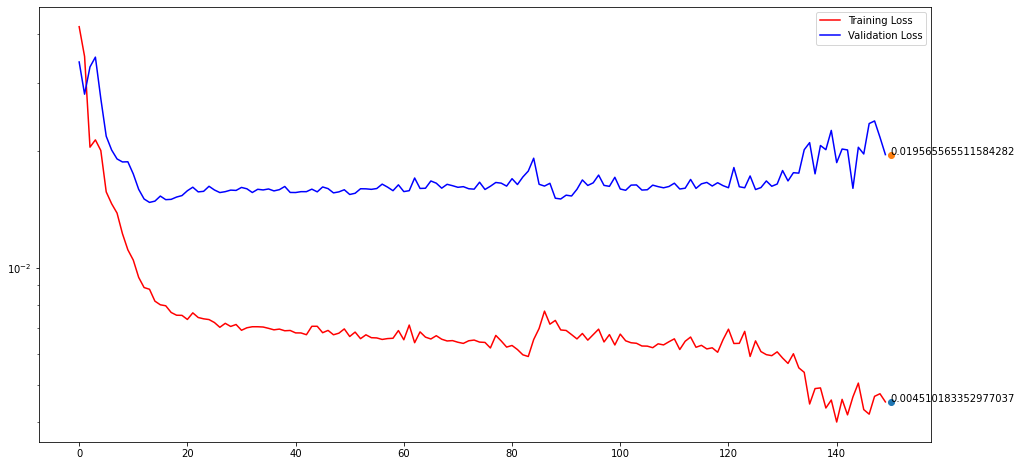

In [131]:
plt.figure(figsize = (16,8))
plt.plot(history22['loss'], color = 'red', label= 'Training Loss')
plt.plot(history22['val_loss'], color = 'blue', label = 'Validation Loss')
plt.scatter(150, history22['loss'][149])
plt.scatter(150, history22['val_loss'][149])
plt.annotate(history22['loss'][149], (150, history22['loss'][149]))
plt.annotate(history22['val_loss'][149], (150, history22['val_loss'][149]))

plt.legend()
plt.yscale("log")
plt.show()

In [94]:
log = pd.read_csv("./training.log", sep = ";")

## Experiment 1

In [171]:
prep = PreProcessor(df.iloc[:,:9])
train_x, test_x, train_y, test_y = prep.pre_process(selected_features, selected_features)

======== Making X and Y Tensors ==========
- - - -  X Tensor founded on Drive - - - - 
- - - -  Reading X TENSOR - - - - 
type:: <class 'numpy.float32'>
Input X by shape: (1754155, 6) is rolled to X Tensor:  (1754027, 128, 6)


In [44]:
history['loss']

[0.0857519581913948, 0.07625195384025574]

In [172]:
model = LSTM_REGRESSION(train_x.shape[1:], n_outputs = train_y.shape[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 50)           11400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [23]:
train_y.shape

(1227818, 6)

In [173]:
history = model.train(train_x[:12278, :, :], train_y[:12278, :], epochs = 100, batch_size = 1000)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 13892323377152.0000 - mae: 1316345.4125

KeyboardInterrupt: 

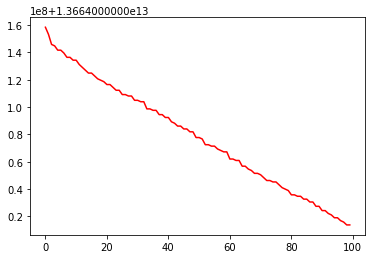

In [47]:
plt.plot(history.history['val_loss'], color = 'red')
plt.show()

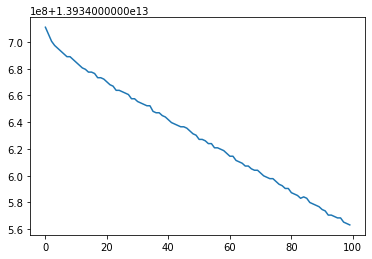

In [42]:
plt.plot(history.history['loss'])

In [48]:
predicted_y = model.predict(test_x[:1000])

In [87]:
predicted_y[0][2]

39.532

In [86]:
test_x[0, 0, 2]

64.49

In [51]:
selected_features

['CUSTOMER_ID',
 'TERMINAL_ID',
 'TX_AMOUNT',
 'TX_TIME_SECONDS',
 'TX_TIME_DAYS',
 'WEEK_DAY']

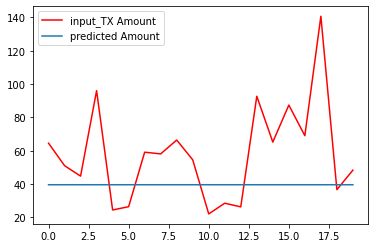

In [125]:
plt.plot(range(20), test_x[:10].reshape(-1, 6)[:20, 2],  color = 'red', label = 'input_TX Amount')
plt.plot(range(20), predicted_y[:1000].reshape(-1, 6)[:20, 2], label = 'predicted Amount')
plt.legend()
plt.show()

In [127]:
train_y.shape

(1227818, 6)

In [135]:
s_train_y = train_y[:,2].reshape(-1, 1)

In [178]:
simple_model = LSTM_REGRESSION(train_x.shape[1:], 
                               lstm_units = 50, 
                               n_outputs = s_train_y.shape[1], 
                               optimizer = optimizers.Adam(learning_rate = 0.01))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128, 50)           11400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [141]:
s_history = simple_model.train(train_x[:12278, :, :], s_train_y[:12278, :], batch_size = 128, epochs = 100)

Epoch 1/100
10/10 [==============================] - 37s 4s/step - loss: 3597.2898 - accuracy: 1.0181e-04 - val_loss: 3937.7959 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 37s 4s/step - loss: 3539.4441 - accuracy: 1.0181e-04 - val_loss: 3880.8352 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 36s 4s/step - loss: 3483.8289 - accuracy: 1.0181e-04 - val_loss: 3829.9255 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 37s 4s/step - loss: 3435.5625 - accuracy: 1.0181e-04 - val_loss: 3782.6719 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 38s 4s/step - loss: 3389.2185 - accuracy: 1.0181e-04 - val_loss: 3737.6865 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 37s 4s/step - loss: 3345.4036 - accuracy: 1.0181e-04 - val_loss: 3694.5659 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 37s 4s/step - los

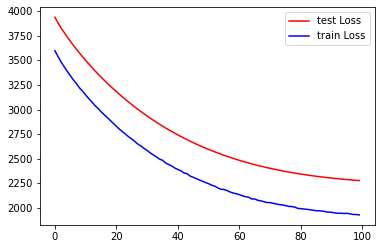

In [147]:
plt.plot(s_history.history['val_loss'], color = 'red', label = 'test Loss')
plt.plot(s_history.history['loss'], color = 'blue', label = 'train Loss')
plt.legend()
plt.show()


In [142]:
spredicted_y = simple_model.predict(test_x[:100])

In [ ]:
plt.plot(spredicted_y[1:100], color = 'black')
# plt.plot(test_y[1:100, 2], color = 'green')
# plt.yscale('log')
plt.show()

In [ ]:
spredicted_ys_history2 = simple_model.train(train_x[:12278, :, :], s_train_y[:12278, :], batch_size = 256, epochs = 100)

Epoch 1/100
39/39 [==============================] - 89s 2s/step - loss: 3729.8156 - mae: 44.6926 - val_loss: 2885.8191 - val_mae: 34.6914
Epoch 2/100
39/39 [==============================] - 75s 2s/step - loss: 2241.7819 - mae: 33.2265 - val_loss: 2360.0891 - val_mae: 32.0993
Epoch 3/100
39/39 [==============================] - 75s 2s/step - loss: 2177.6661 - mae: 32.3880 - val_loss: 2245.8137 - val_mae: 32.2046
Epoch 4/100
39/39 [==============================] - 74s 2s/step - loss: 1912.0968 - mae: 32.5464 - val_loss: 2231.4407 - val_mae: 32.4936
Epoch 5/100
39/39 [==============================] - 76s 2s/step - loss: 1865.8628 - mae: 32.5959 - val_loss: 2229.8596 - val_mae: 32.5996
Epoch 6/100
39/39 [==============================] - 77s 2s/step - loss: 2066.4290 - mae: 32.8376 - val_loss: 2229.7385 - val_mae: 32.6149
Epoch 7/100
39/39 [==============================] - 74s 2s/step - loss: 1752.7627 - mae: 32.3419 - val_loss: 2229.7603 - val_mae: 32.6119
Epoch 8/100
39/39 [========

In [160]:
test_y[:, 2]

array([  0.86,  48.24,  87.32, ..., 105.81,  55.4 ,  23.59], dtype=float32)

In [16]:
pr = Preprocessor(df.iloc[:4000, :10])
train_x, test_x, train_y, test_y = pr.pre_process(selected_features, 
               ["TX_AMOUNT"],
               numericals = [["TX_AMOUNT", "TX_TIME_SECONDS",'TX_TIME_DAYS'],["TX_AMOUNT"]],
              categoricals = [["CUSTOMER_ID", "TERMINAL_ID", "WEEK_DAY", "TX_FRAUD_SCENARIO"],None])
               

(4000, 7)
(4000, 5727)
======== Making X and Y Tensors ==========
- - - -  X Tensor founded on Local Drive - - - - 
- - - -  Reading X TENSOR - - - - 
type:: <class 'numpy.float64'>
Input X by shape: (4000, 5727) is rolled to X Tensor:  (3872, 128, 5727)


In [18]:
normal_model = LSTM_REGRESSION(train_x.shape[1:], 
                               lstm_units = 80, 
                               n_outputs = train_y.shape[1], 
                               optimizer = optimizers.Adam(learning_rate = 0.01))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 80)           1858560   
_________________________________________________________________
dropout (Dropout)            (None, 128, 80)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 80)           51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

In [ ]:
n_history = normal_model.train(train_x, train_y, epochs = 100)

In [19]:
with open("n_history_n.pickle", 'rb') as file:
    n_history = pickle.load(file)

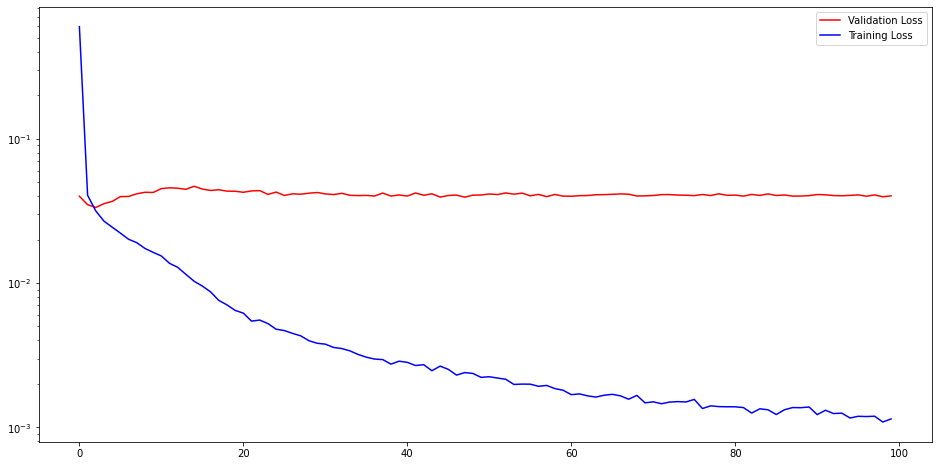

In [29]:
plt.figure(figsize=(16,8))
plt.plot(n_history['val_loss'], color = 'red', label = 'Validation Loss')
plt.plot(n_history['loss'], color = 'blue', label = 'Training Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
        if self.rol_base == 'time':
            ix_tensor = np.zeros([(self.data.shape[0] - (window_size)) * window_size, len(self.features)], dtype = 'float32')
            iy_tensor = np.zeros((0, len(self.labels)), dtype = 'float32')
            dg_x = self.data[[col for col in self.data.columns if col.startswith(tuple(self.features))]]
            dg_y = self.data[[col for col in self.data.columns if col.startswith(tuple(self.labels))]]

#             starts = np.array(range(self.data_x.shape[0]-(window_size)))
            if os.path.isfile('ix_tensor.pickle'):
                print("- - - -  X Tensor founded on Local Drive - - - - ")
                print("- - - -  Reading X TENSOR - - - - ")
                with open('ix_tensor.pickle', 'rb') as file:
                    ix_tensor = joblib.load(file)
                with open('iy_tensor.pickle', 'rb') as file:
                    iy_tensor = joblib.load(file)
            else:
                #Rolling Loop for making ix_tensor
                for i in tqdm(range(dg_x.shape[0]-(window_size))):
                    s = np.array(dg_x[i:i+window_size], dtype='float32')
                    ix_tensor[(window_size*i):(window_size*(i+1)), :] = s
                    iy_tensor = np.vstack((iy_tensor, dg_y.iloc[i+window_size, ]))
                ix_tensor = ix_tensor.reshape(-1, window_size, np.shape(ix_tensor)[1])
                print("- - - - Writing X Tensor on Drive- - - -")
                with open('ix_tensor.pickle', 'wb') as file:
                    joblib.dump(ix_tensor, file)
                with open('iy_tensor.pickle', 'wb') as file:
                    joblib.dump(iy_tensor, file) 
            print("type:",type(iy_tensor[0][0]))
        else:
